Este es un modelo de red covolucional para detectar profundidad en imágenes. Es un autoencoder cuya estructura de codificación es la red pre-entrenada VGG16 con los pesos de IMAGENET.
El paso de codificación es una serie de convolucionales transpuestas.

Sobre los datos, se está haciendo uso de un subconjunto del dataset disponible en https://www.cvlibs.net/datasets/kitti/eval_depth_all.php en el que se hace aumentación de datos para buscar mejores resultados.


In [ ]:
import os
import cv2
import numpy as np
import tensorflow as tf
from sklearn.model_selection import train_test_split
from tensorflow.keras import layers, models
from tensorflow.keras.applications import VGG16
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import MeanSquaredError
from tensorflow.keras.callbacks import ModelCheckpoint
import matplotlib.pyplot as plt

In [ ]:
# función para cargar imágenes de la carpeta
def load_images_and_depth_maps(data_dir, input_shape, flip=True):
    images = []
    depth_maps = []

    folders = os.listdir(data_dir)

    for folder in folders:
        image_folder = os.path.join(data_dir, folder, "image")
        depth_map_folder = os.path.join(data_dir, folder, "groundtruth_depth")

        image_files = os.listdir(image_folder)
        depth_map_files = os.listdir(depth_map_folder)

        for image_file, depth_map_file in zip(image_files, depth_map_files):
            image_path = os.path.join(image_folder, image_file)
            image = cv2.imread(image_path)
            image = cv2.resize(image, (input_shape[1], input_shape[0]))

            depth_map_path = os.path.join(depth_map_folder, depth_map_file)
            depth_map = cv2.imread(depth_map_path, cv2.IMREAD_GRAYSCALE)
            depth_map = cv2.resize(depth_map, (input_shape[1], input_shape[0]))

            images.append(image)
            depth_maps.append(depth_map)

            if flip:
                # Augment data by flipping horizontally
                flipped_image = cv2.flip(image, 1)
                flipped_depth_map = cv2.flip(depth_map, 1)
                images.append(flipped_image)
                depth_maps.append(flipped_depth_map)

    return np.array(images), np.array(depth_maps)

In [ ]:
# Directorio donde se encuentran las carpetas "image" y "depth_map"
data_dir = "/datos"
# Dimensiones de entrada para las imágenes (224x224)
input_shape = (256, 256)
# carga de imágenes con data augmentation
X, y = load_images_and_depth_maps(data_dir, input_shape)

# Show the shape of augmented data
print("Shape of augmented X:", X.shape)
print("Shape of augmented y:", y.shape)

Mounted at /content/drive
Shape of augmented X: (4000, 256, 256, 3)
Shape of augmented y: (4000, 256, 256)


In [ ]:
# Dividir los datos en entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
# Definir las dimensiones de entrada y salida
input_shape = (3, 256, 256)  
output_shape = (1, 256, 256)  

# Definir otros parámetros del modelo
num_epochs = 30
batch_size = 32

# Mostrar la forma de los conjuntos de entrenamiento y prueba
print("Shape of X_train:", X_train.shape)
print("Shape of X_test:", X_test.shape)
print("Shape of y_train:", y_train.shape)
print("Shape of y_test:", y_test.shape)

Shape of X_train: (3200, 256, 256, 3)
Shape of X_test: (800, 256, 256, 3)
Shape of y_train: (3200, 256, 256)
Shape of y_test: (800, 256, 256)


In [ ]:
# Definir las dimensiones de entrada y salida
input_shape = (256, 256, 3)  # Imágenes RGB de 224x224 pixeles
latent_dim = (8, 8, 32)  # Espacio latente de 8x8x32

# Cargar el modelo VGG16 preentrenado
base_model = VGG16(weights='imagenet', include_top=False, input_shape=input_shape)

# Congelar las capas del modelo base
base_model.trainable = False

# Definir el decoder convolucional

decoder = models.Sequential([
    layers.Conv2DTranspose(256, kernel_size=4, strides=2, padding='same', activation='relu'),
    layers.Conv2DTranspose(128, kernel_size=4, strides=2, padding='same', activation='relu'),
    layers.Conv2DTranspose(64, kernel_size=4, strides=2, padding='same', activation='relu'),
    layers.Conv2DTranspose(32, kernel_size=4, strides=2, padding='same', activation='relu'),
    layers.Conv2DTranspose(1, kernel_size=4, strides=2, padding='same', activation='sigmoid')
])


# Definir el modelo completo
inputs = tf.keras.Input(shape=input_shape)
x = base_model(inputs)
x = layers.Flatten()(x)
latent_space = layers.Dense(np.prod(latent_dim))(x)
latent_space = layers.Reshape(latent_dim)(latent_space)
outputs = decoder(latent_space)

# Compilar el modelo
autoencoder = models.Model(inputs, outputs)
autoencoder.compile(optimizer=Adam(), loss=MeanSquaredError())

# Mostrar el resumen del modelo
autoencoder.summary()

58889256/58889256 [==============================] - 4s 0us/step
Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 256, 256, 3)]     0         
                                                                 
 vgg16 (Functional)          (None, 8, 8, 512)         14714688  
                                                                 
 flatten (Flatten)           (None, 32768)             0         
                                                                 
 dense (Dense)               (None, 2048)              67110912  
                                                                 
 reshape (Reshape)           (None, 8, 8, 32)          0         
                                                                 
 sequential (Sequential)     (None, 256, 256, 1)       820193    
                                                              

In [ ]:
# Definir el callback para guardar el mejor modelo durante el entrenamiento
checkpoint_callback = ModelCheckpoint("best_model.h5", monitor='val_loss', save_best_only=True)

# Entrenar el modelo
history = autoencoder.fit(X_train, y_train,
                          epochs=num_epochs,
                          batch_size=batch_size,
                          validation_data=(X_test, y_test),
                          callbacks=[checkpoint_callback])

# Guardar el modelo entrenado
autoencoder.save("final_model.h5")

Epoch 1/30
100/100 [==============================] - ETA: 0s - loss: 24.2227

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


100/100 [==============================] - 44s 305ms/step - loss: 24.2227 - val_loss: 23.6691
Epoch 2/30
100/100 [==============================] - 33s 330ms/step - loss: 24.1365 - val_loss: 23.5827
Epoch 3/30
100/100 [==============================] - 30s 300ms/step - loss: 24.0549 - val_loss: 23.5783
Epoch 4/30
100/100 [==============================] - 31s 315ms/step - loss: 24.0404 - val_loss: 23.5749
Epoch 5/30
100/100 [==============================] - 25s 247ms/step - loss: 24.0306 - val_loss: 23.5761
Epoch 6/30
100/100 [==============================] - 24s 239ms/step - loss: 24.0231 - val_loss: 23.5820
Epoch 7/30
100/100 [==============================] - 24s 240ms/step - loss: 24.0167 - val_loss: 23.5849
Epoch 8/30
100/100 [==============================] - 24s 241ms/step - loss: 24.0098 - val_loss: 23.5896
Epoch 9/30
100/100 [==============================] - 24s 242ms/step - loss: 24.0035 - val_loss: 23.5939
Epoch 10/30
100/100 [==============================] - 24s 242ms/s

25/25 [==============================] - 4s 163ms/step


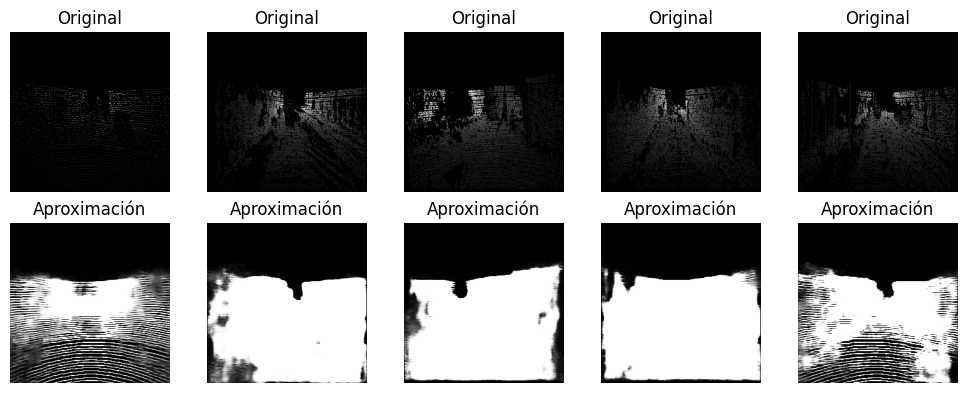

In [ ]:
# Generar imágenes reconstruidas
reconstructed_images = autoencoder.predict(X_test)

# Elegir algunas muestras aleatorias para visualizar
num_samples = 5
random_indices = np.random.choice(len(X_test), num_samples, replace=False)

# Visualizar imágenes originales y reconstruidas
plt.figure(figsize=(10, 4))
for i, idx in enumerate(random_indices):
    # Imagen original
    plt.subplot(2, num_samples, i + 1)
    plt.imshow(y_test[idx], cmap='gray')
    plt.title('Original')
    plt.axis('off')

    # Imagen reconstruida
    plt.subplot(2, num_samples, num_samples + i + 1)
    plt.imshow(reconstructed_images[idx], cmap='gray')
    plt.title('Aproximación')
    plt.axis('off')

plt.tight_layout()
plt.show()

In [ ]:
num_epochs_full_training = 5

25/25 [==============================] - 4s 165ms/step


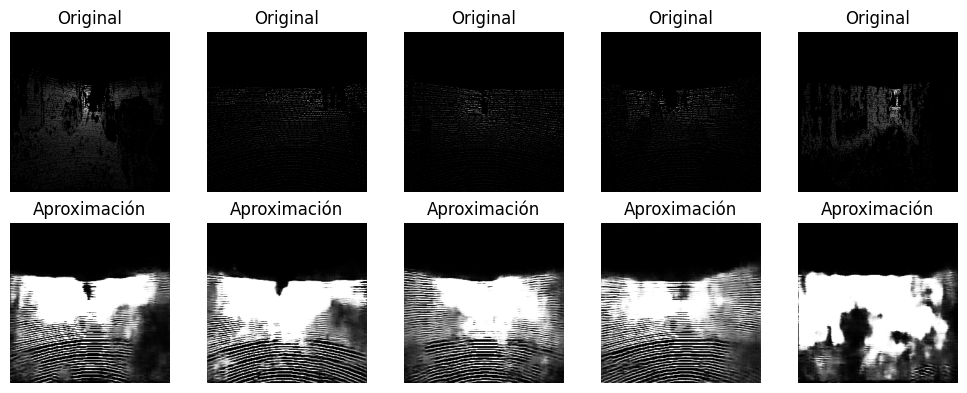

In [ ]:
# Generar imágenes reconstruidas
reconstructed_images = autoencoder.predict(X_test)

# Elegir algunas muestras aleatorias para visualizar
num_samples = 5
random_indices = np.random.choice(len(X_test), num_samples, replace=False)

# Visualizar imágenes originales y reconstruidas
plt.figure(figsize=(10, 4))
for i, idx in enumerate(random_indices):
    # Imagen original
    plt.subplot(2, num_samples, i + 1)
    plt.imshow(y_test[idx], cmap='gray')
    plt.title('Original')
    plt.axis('off')

    # Imagen reconstruida
    plt.subplot(2, num_samples, num_samples + i + 1)
    plt.imshow(reconstructed_images[idx], cmap='gray')
    plt.title('Aproximación')
    plt.axis('off')

plt.tight_layout()
plt.show()

In [ ]:
# Ajuste completo (full training)
autoencoder.trainable = True
autoencoder.compile(optimizer=Adam(learning_rate=0.0001), loss=MeanSquaredError())
autoencoder.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 256, 256, 3)]     0         
                                                                 
 vgg16 (Functional)          (None, 8, 8, 512)         14714688  
                                                                 
 flatten (Flatten)           (None, 32768)             0         
                                                                 
 dense (Dense)               (None, 2048)              67110912  
                                                                 
 reshape (Reshape)           (None, 8, 8, 32)          0         
                                                                 
 sequential (Sequential)     (None, 256, 256, 1)       820193    
                                                                 
Total params: 82645793 (315.27 MB)
Trainable params: 82645793

In [ ]:
# Definir el callback para guardar el mejor modelo durante el entrenamiento
checkpoint_callback = ModelCheckpoint("best_model_full.h5", monitor='val_loss', save_best_only=True)
autoencoder.fit(X_train, y_train, epochs=num_epochs_full_training, validation_data=(X_test, y_test), callbacks=[checkpoint_callback])

Epoch 1/5
100/100 [==============================] - 75s 705ms/step - loss: 23.9482 - val_loss: 23.6675
Epoch 2/5
100/100 [==============================] - 59s 588ms/step - loss: 23.9345 - val_loss: 23.6700
Epoch 3/5
100/100 [==============================] - 59s 590ms/step - loss: 23.9340 - val_loss: 23.6788
Epoch 4/5
100/100 [==============================] - 61s 606ms/step - loss: 23.9324 - val_loss: 23.6684
Epoch 5/5
100/100 [==============================] - 61s 607ms/step - loss: 23.9306 - val_loss: 23.6723


25/25 [==============================] - 4s 165ms/step


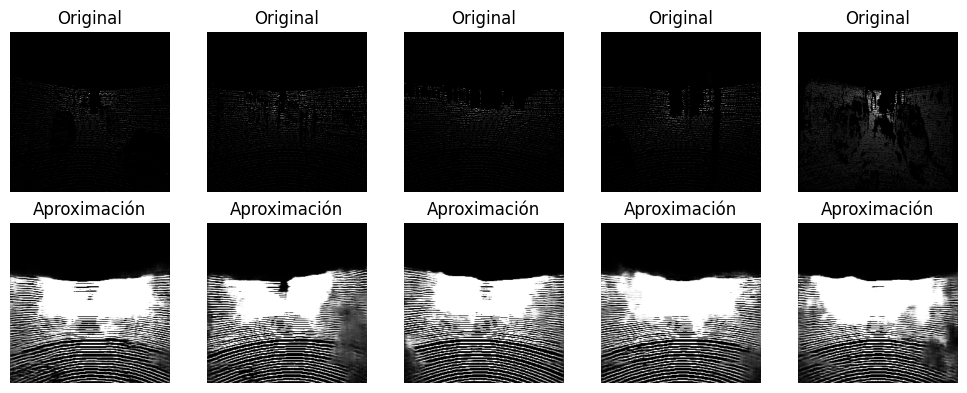

In [ ]:
# Generar imágenes reconstruidas
reconstructed_images = autoencoder.predict(X_test)

# Elegir algunas muestras aleatorias para visualizar
num_samples = 5
random_indices = np.random.choice(len(X_test), num_samples, replace=False)

# Visualizar imágenes originales y reconstruidas
plt.figure(figsize=(10, 4))
for i, idx in enumerate(random_indices):
    # Imagen original
    plt.subplot(2, num_samples, i + 1)
    plt.imshow(y_test[idx], cmap='gray')
    plt.title('Original')
    plt.axis('off')

    # Imagen reconstruida
    plt.subplot(2, num_samples, num_samples + i + 1)
    plt.imshow(reconstructed_images[idx], cmap='gray')
    plt.title('Aproximación')
    plt.axis('off')

plt.tight_layout()
plt.show()
